# Space Biology — Data Exploration & Preprocessing
**Goals**
- Load `SB_publication_PMC.csv`
- Fetch abstract / full text from PMC links (robust parsing + caching)
- Basic EDA (counts, top words, timeline)
- Preprocess text (clean, lemmatize)
- Topic modeling (BERTopic / LDA fallback)
- Create sentence / document embeddings (SentenceTransformers)
- Build FAISS index for semantic search
- Export cleaned dataset + embeddings for backend


In [1]:
# Cell 1 - Environment setup (Colab-friendly)
# Run this cell in Colab to install dependencies. On local Jupyter, pip install equivalents.
!pip install -q sentence-transformers==2.2.2 transformers==4.33.2 requests beautifulsoup4 lxml tqdm faiss-cpu scikit-learn nltk spacy bertopic[all] pandas matplotlib seaborn

# (Optional) if spacy model missing:
!python -m spacy download en_core_web_sm

  DEPRECATION: Building 'sentence-transformers' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'sentence-transformers'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  error: subprocess-exited-with-error
  
  exit code: 1
  
  [62 lines of output]
  C:\Users\l\AppData\Local\Temp\pip-build-env-8joqhg8w\overlay\Lib\site-packages\setuptools\dist.py:759: SetuptoolsDeprecationWarning: License classifiers are deprecated.
  !!
  
          ********************************************************************************
          Please consider removing the following classifiers in favor of a SPDX license expression:
  
          License :: OSI Approved :: Apache Software Licens

In [6]:
!pip install nltk
!pip install -U sentence-transformers


  Using cached torch-2.8.0-cp312-cp312-win_amd64.whl.metadata (30 kB)
  Using cached huggingface_hub-0.35.3-py3-none-any.whl.metadata (14 kB)
  Using cached safetensors-0.6.2-cp38-abi3-win_amd64.whl.metadata (4.1 kB)
  Using cached fsspec-2025.9.0-py3-none-any.whl.metadata (10 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.5-py3-none-any.whl.metadata (6.3 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ---------------------------------------- 0.0/12.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.0 MB ? eta -:--:--
    ------------------------------------

In [12]:
!pip install tf-keras
!pip install faiss-cpu
!pip install bertopic
!pip install requests
!pip install beautifulsoup4
!pip install lxml
!pip install tqdm

  Using cached bertopic-0.17.3-py3-none-any.whl.metadata (24 kB)
  Using cached hdbscan-0.8.40-cp312-cp312-win_amd64.whl.metadata (15 kB)
  Using cached umap_learn-0.5.9.post2-py3-none-any.whl.metadata (25 kB)
  Using cached plotly-6.3.1-py3-none-any.whl.metadata (8.5 kB)
  Using cached llvmlite-0.45.1-cp312-cp312-win_amd64.whl.metadata (5.0 kB)
  Using cached narwhals-2.6.0-py3-none-any.whl.metadata (11 kB)
  Using cached numba-0.62.1-cp312-cp312-win_amd64.whl.metadata (2.9 kB)
  Using cached pynndescent-0.5.13-py3-none-any.whl.metadata (6.8 kB)
Using cached bertopic-0.17.3-py3-none-any.whl (153 kB)
Using cached hdbscan-0.8.40-cp312-cp312-win_amd64.whl (726 kB)
Using cached llvmlite-0.45.1-cp312-cp312-win_amd64.whl (38.1 MB)
Using cached plotly-6.3.1-py3-none-any.whl (9.8 MB)
Using cached narwhals-2.6.0-py3-none-any.whl (408 kB)
Using cached umap_learn-0.5.9.post2-py3-none-any.whl (90 kB)
Using cached numba-0.62.1-cp312-cp312-win_amd64.whl (2.7 MB)
Using cached pynndescent-0.5.13-py3-

In [15]:
# Cell 2 - Imports
import os
import time
import json
import re
import math
from pathlib import Path
from typing import Optional, Dict, Any, List, Tuple

import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from tqdm.auto import tqdm

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sentence_transformers import SentenceTransformer
import faiss

# Topic modeling
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer

import matplotlib.pyplot as plt
import seaborn as sns



In [16]:
# Cell 3 - NLTK setup (only first-run)
nltk.download('punkt')
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\l\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\l\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [17]:
# Cell 4 - Paths & config
ROOT = Path.cwd()
DATA_DIR = ROOT / "datasets"
CACHE_DIR = ROOT / "cache"
DATA_DIR.mkdir(parents=True, exist_ok=True)
CACHE_DIR.mkdir(parents=True, exist_ok=True)

CSV_PATH = DATA_DIR / "SB_publication_PMC.csv"  # If running from repo, copy CSV here or mount repo
OUTPUT_CLEAN_CSV = DATA_DIR / "sb_publications_clean.csv"
EMBEDDING_NPY = DATA_DIR / "embeddings.npy"
METADATA_JSON = DATA_DIR / "metadata.json"

# Choose embedding model & dimension
EMBED_MODEL_NAME = "all-MiniLM-L6-v2"  # 384-dim; fast for hackathon
EMBED_DIM = 384

In [18]:
# Cell 5 - Load CSV
# If running in Colab, you may need to `!wget` or mount the repo first.
if not CSV_PATH.exists():
    # fallback: try to download raw CSV from the user's GitHub repo
    raw_url = "https://raw.githubusercontent.com/jgalazka/SB_publications/main/SB_publication_PMC.csv"
    print("Downloading CSV from repo:", raw_url)
    r = requests.get(raw_url)
    if r.status_code == 200:
        CSV_PATH.write_bytes(r.content)
    else:
        raise FileNotFoundError(f"CSV not found locally and could not download (status {r.status_code})")

df = pd.read_csv(CSV_PATH, names=["title", "link"], header=0)
print("Loaded:", df.shape)
df.head(5)


Loaded: (607, 2)


,title,link
0,Mice in Bion-M 1 space mission: training and s...,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...
1,Microgravity induces pelvic bone loss through ...,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...
2,Stem Cell Health and Tissue Regeneration in Mi...,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...
3,Microgravity Reduces the Differentiation and R...,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...
4,Microgravity validation of a novel system for ...,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...


In [19]:
# Cell 6 - Quick EDA
print("Total rows:", len(df))
print("Sample titles:")
print(df['title'].sample(10).tolist())

# Check for duplicate or missing links
print("Missing links:", df['link'].isna().sum())
print("Duplicates (links):", df['link'].duplicated().sum())


Total rows: 607
Sample titles:
['Fifteen days of microgravity causes growth in calvaria of mice', 'Telomeric RNA (TERRA) increases in response to spaceflight and high-altitude climbing', 'Metabolic modeling of the International Space Station microbiome reveals key microbial interactions.', 'Functional changes in the snail statocyst system elicited by microgravity', 'Validation of methods to assess the immunoglobulin gene repertoire in tissues obtained from mice on the International Space Station.', 'Leptin and environmental temperature as determinants of bone marrow adiposity in female mice', "A parasitoid wasp of Drosophila employs preemptive and reactive strategies to deplete its host's blood cells", 'Space radiation damage rescued by inhibition of key spaceflight associated miRNAs', 'NASA open science data repository: Open science for life in space.', 'Spaceflight alters host-gut microbiota interactions']
Missing links: 0
Duplicates (links): 35


In [20]:
# Cell 7 - Helper: robust PMC fetcher with caching
import hashlib

def cache_path_for_url(url: str) -> Path:
    h = hashlib.sha1(url.encode()).hexdigest()
    return CACHE_DIR / f"{h}.html"

def fetch_pmc_html(url: str, sleep: float = 0.8, force_refresh: bool = False) -> Optional[str]:
    cp = cache_path_for_url(url)
    if cp.exists() and not force_refresh:
        return cp.read_text(encoding="utf-8")
    try:
        headers = {"User-Agent": "SpaceBioBot/1.0 (contact: your-email@example.com)"}
        r = requests.get(url, headers=headers, timeout=20)
        if r.status_code == 200:
            cp.write_text(r.text, encoding="utf-8")
            time.sleep(sleep)  # polite delay
            return r.text
        else:
            print("Fetch failed", url, r.status_code)
            return None
    except Exception as e:
        print("Error fetching", url, e)
        return None

# Parser: attempt to extract abstract and main text
def parse_pmc_for_text(html: str) -> Dict[str, str]:
    soup = BeautifulSoup(html, "lxml")
    # Abstracts on PMC often in <div class="abstract"> or <abstract>
    abstract = ""
    # Try multiple selectors robustly
    selectors = [
        ("div", {"class": re.compile("abstract", re.I)}),
        ("section", {"class": re.compile("abstract", re.I)}),
        ("abstract", {}),
        ("div", {"id": re.compile("abstract", re.I)}),
    ]
    for tag, attrs in selectors:
        node = soup.find(tag, attrs=attrs)
        if node:
            abstract = node.get_text(separator=" ", strip=True)
            break
    # If not found, try meta tags
    if not abstract:
        meta = soup.find("meta", {"name": "description"})
        if meta and meta.get("content"):
            abstract = meta["content"]
    # Extract title if present
    title = ""
    if soup.title:
        title = soup.title.get_text()
    # Extract main body text
    body = ""
    # Many PMCs have <div class="tsec"> or <div class="body"> or <div id="maincontent">
    body_selectors = [
        ("div", {"class": re.compile("body|article-body|tsec", re.I)}),
        ("div", {"id": re.compile("main", re.I)}),
        ("article", {}),
        ("div", {"class": re.compile("content", re.I)}),
    ]
    for tag, attrs in body_selectors:
        node = soup.find(tag, attrs=attrs)
        if node:
            body = node.get_text(separator=" ", strip=True)
            break
    # Last-resort: join all <p> tags
    if not body:
        ps = soup.find_all("p")
        if ps:
            body = " ".join([p.get_text(separator=" ", strip=True) for p in ps])
    return {"title": title, "abstract": abstract, "body": body}


In [21]:
# Cell 8 - Fetch abstracts & sample pages (safe loop with progress & caching)
# For hackathon, fetch a smaller subset first (e.g., first 120) or set all=True
MAX_FETCH = 200  # set to len(df) or smaller during prototyping
records = []

for idx, row in tqdm(df.head(MAX_FETCH).iterrows(), total=min(MAX_FETCH, len(df))):
    url = row['link']
    rec = {"orig_title": row['title'], "link": url}
    try:
        html = fetch_pmc_html(url)
        if html:
            parsed = parse_pmc_for_text(html)
            rec.update(parsed)
        else:
            rec.update({"title": "", "abstract": "", "body": ""})
    except Exception as e:
        print("Error parsing", url, e)
        rec.update({"title": "", "abstract": "", "body": ""})
    records.append(rec)

meta_df = pd.DataFrame(records)
print("Fetched:", len(meta_df))
meta_df.head(5)


  0%|          | 0/200 [00:00<?, ?it/s]

Error fetching https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4136787/ HTTPSConnectionPool(host='www.ncbi.nlm.nih.gov', port=443): Max retries exceeded with url: /pmc/articles/PMC4136787/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000190CB6D77A0>: Failed to resolve 'www.ncbi.nlm.nih.gov' ([Errno 11001] getaddrinfo failed)"))
Error parsing https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3630201/ Couldn't find a tree builder with the features you requested: lxml. Do you need to install a parser library?
Error parsing https://www.ncbi.nlm.nih.gov/pmc/articles/PMC11988870/ Couldn't find a tree builder with the features you requested: lxml. Do you need to install a parser library?
Error parsing https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7998608/ Couldn't find a tree builder with the features you requested: lxml. Do you need to install a parser library?
Error parsing https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5587110/ Couldn't find a tree builder with th

,orig_title,link,title,abstract,body
0,Mice in Bion-M 1 space mission: training and s...,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...,,,
1,Microgravity induces pelvic bone loss through ...,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,,,
2,Stem Cell Health and Tissue Regeneration in Mi...,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,,,
3,Microgravity Reduces the Differentiation and R...,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,,,
4,Microgravity validation of a novel system for ...,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,,,


In [22]:
# Cell 9 - Merge with original CSV (keep link/title from CSV as canonical)
merged = df.merge(meta_df, left_on="link", right_on="link", how="left", suffixes=("", "_parsed"))
# prefer parsed title if CSV title empty
merged['final_title'] = merged['title'].fillna(merged['title_parsed']).fillna("No title")
# combined_text: prefer abstract, otherwise body, else title
def choose_text(row):
    if isinstance(row.get("abstract"), str) and row["abstract"].strip():
        return row["abstract"]
    if isinstance(row.get("body"), str) and row["body"].strip():
        return row["body"]
    return row["title"]
merged['text'] = merged.apply(choose_text, axis=1)
merged = merged[['final_title', 'link', 'text']].rename(columns={'final_title': 'title'})
print("Final dataset:", merged.shape)
merged.head(3)


Final dataset: (624, 3)


,title,link,text
0,Mice in Bion-M 1 space mission: training and s...,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...,Mice in Bion-M 1 space mission: training and s...
1,Microgravity induces pelvic bone loss through ...,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,Microgravity induces pelvic bone loss through ...
2,Stem Cell Health and Tissue Regeneration in Mi...,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,Stem Cell Health and Tissue Regeneration in Mi...


In [24]:
!pip install spacy

  Using cached spacy-3.8.7-cp312-cp312-win_amd64.whl.metadata (28 kB)
  Using cached spacy_legacy-3.0.12-py2.py3-none-any.whl.metadata (2.8 kB)
  Using cached spacy_loggers-1.0.5-py3-none-any.whl.metadata (23 kB)
  Using cached murmurhash-1.0.13-cp312-cp312-win_amd64.whl.metadata (2.2 kB)
  Using cached cymem-2.0.11-cp312-cp312-win_amd64.whl.metadata (8.8 kB)
  Using cached preshed-3.0.10-cp312-cp312-win_amd64.whl.metadata (2.5 kB)
  Using cached thinc-8.3.6-cp312-cp312-win_amd64.whl.metadata (15 kB)
  Using cached wasabi-1.1.3-py3-none-any.whl.metadata (28 kB)
  Using cached srsly-2.5.1-cp312-cp312-win_amd64.whl.metadata (20 kB)
  Using cached catalogue-2.0.10-py3-none-any.whl.metadata (14 kB)
  Using cached weasel-0.4.1-py3-none-any.whl.metadata (4.6 kB)
  Using cached typer-0.19.2-py3-none-any.whl.metadata (16 kB)
  Using cached langcodes-3.5.0-py3-none-any.whl.metadata (29 kB)
  Using cached language_data-1.3.0-py3-none-any.whl.metadata (4.3 kB)
  Using cached annotated_types-0.7.0

In [26]:
# Cell 10 - Basic text cleaning functions
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')   # newer versions sometimes need this
nltk.download('stopwords')
nltk.download('wordnet')

import unicodedata
from spacy.lang.en import English
nlp_tokenizer = English().tokenizer

def clean_text(text: str) -> str:
    if not isinstance(text, str) or not text.strip():
        return ""
    # normalize
    text = unicodedata.normalize("NFKD", text)
    # remove excessive whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    # remove references like [1], (1), Fig. 1 etc. (simple)
    text = re.sub(r'\[[0-9]+\]', ' ', text)
    text = re.sub(r'\(Fig.*?\)', ' ', text)
    return text

def simple_tokenize(text: str) -> List[str]:
    tokens = [w.lower() for w in word_tokenize(text)]
    tokens = [re.sub(r'[^a-z]', '', w) for w in tokens]
    tokens = [t for t in tokens if t and t not in STOPWORDS and len(t) > 2]
    return tokens

merged['clean_text'] = merged['text'].fillna("").apply(clean_text)
merged['word_count'] = merged['clean_text'].apply(lambda x: len(simple_tokenize(x)))
merged = merged[merged['clean_text'].str.len() > 10].reset_index(drop=True)
print("After cleaning & filter:", merged.shape)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\l\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\l\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\l\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\l\AppData\Roaming\nltk_data...


After cleaning & filter: (624, 5)


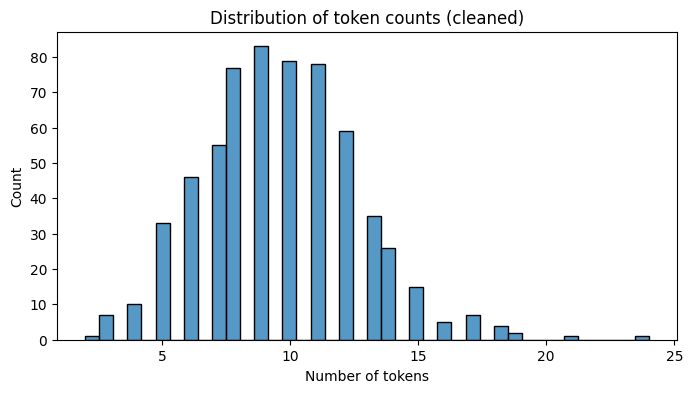

space 140
spaceflight 125
international 66
station 64
microgravity 58
arabidopsis 47
bone 46
mice 44
effects 44
response 42
gene 33
cell 32
plant 32
simulated 31
cells 30
expression 30
isolated 30
radiation 29
genome 29
mouse 27
muscle 27
signaling 27
characterization 27
analysis 26
growth 26


In [27]:
# Cell 11 - Quick EDA visuals (word counts distribution)
plt.figure(figsize=(8,4))
sns.histplot(merged['word_count'], bins=40)
plt.title("Distribution of token counts (cleaned)")
plt.xlabel("Number of tokens")
plt.show()

# Show top frequent tokens across corpus
from collections import Counter
all_tokens = Counter()
merged['clean_text'].apply(lambda t: all_tokens.update(simple_tokenize(t)))
for token, cnt in all_tokens.most_common(25):
    print(token, cnt)


In [28]:
# Cell 12 - Topic modeling with BERTopic (fast option)
# Convert to short documents: use first 1200 chars to speed up
docs = merged['clean_text'].apply(lambda t: t[:1200]).tolist()

# BERTopic may automatically install umap/hdbscan dependencies; if heavy, consider LDA fallback
print("Running BERTopic (this may take a few minutes)...")
topic_model = BERTopic(language="english", calculate_probabilities=False, verbose=False)
topics, probs = topic_model.fit_transform(docs)

merged['topic'] = topics
topic_model.get_topic_info().head(10)


Running BERTopic (this may take a few minutes)...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

,Topic,Count,Name,Representation,Representative_Docs
0,-1,55,-1_stem_of_and_the,"[stem, of, and, the, on, antibody, skeletal, i...",[Effects of skeletal unloading on the bone mar...
1,0,146,0_of_the_station_international,"[of, the, station, international, space, from,...",[Draft Genome Sequences of Klebsiella Species ...
2,1,131,1_arabidopsis_in_plant_of,"[arabidopsis, in, plant, of, thaliana, signali...",[A novel blue-light phototropic response is re...
3,2,110,2_spaceflight_and_mouse_of,"[spaceflight, and, mouse, of, the, in, to, on,...",[Effects of spaceflight aboard the Internation...
4,3,73,3_bone_in_mice_and,"[bone, in, mice, and, unloading, loss, rats, l...",[Leptin and environmental temperature as deter...
5,4,32,4_radiation_and_ionizing_exposure,"[radiation, and, ionizing, exposure, irradiati...",[Dose- and Ion-Dependent Effects in the Oxidat...
6,5,26,5_omics_for_data_science,"[omics, for, data, science, space, nasa, life,...",[Inspiration4 data access through the NASA Ope...
7,6,22,6_drosophila_melanogaster_of_parasitoids,"[drosophila, melanogaster, of, parasitoids, ho...",[Spaceflight and simulated microgravity condit...
8,7,17,7_elegans_caenorhabditis_in_strength,"[elegans, caenorhabditis, in, strength, for, m...",[Transcriptomic Signature of the Simulated Mic...
9,8,12,8_mscl_mechanosensitive_channels_channel,"[mscl, mechanosensitive, channels, channel, th...",[Expressing and Characterizing Mechanosensitiv...


In [29]:
# Cell 13 - Inspect top topics
for t in merged['topic'].value_counts().head(10).index:
    print("Topic", t)
    print(topic_model.get_topic(t))
    print("-----")


Topic 0
[('of', np.float64(0.07030073257796045)), ('the', np.float64(0.06866926158457662)), ('station', np.float64(0.0682001320169353)), ('international', np.float64(0.06745927659335957)), ('space', np.float64(0.06389468575886201)), ('from', np.float64(0.062378104748167386)), ('isolated', np.float64(0.04665206560867496)), ('and', np.float64(0.04352960788514331)), ('genome', np.float64(0.0406109817830297)), ('draft', np.float64(0.03596225633217724))]
-----
Topic 1
[('arabidopsis', np.float64(0.08956550256511557)), ('in', np.float64(0.07041378008638947)), ('plant', np.float64(0.06436905609758628)), ('of', np.float64(0.05090966056571078)), ('thaliana', np.float64(0.050664793025763676)), ('signaling', np.float64(0.04956377688635819)), ('root', np.float64(0.04887479964569281)), ('the', np.float64(0.04792391752041175)), ('and', np.float64(0.045926276082874425)), ('plants', np.float64(0.04398731968112353))]
-----
Topic 2
[('spaceflight', np.float64(0.08375240439248717)), ('and', np.float64(0.

In [30]:
# Cell 14 - Compute embeddings (SentenceTransformers)
print("Loading model:", EMBED_MODEL_NAME)
embed_model = SentenceTransformer(EMBED_MODEL_NAME)

# For embeddings we typically use title + abstract snippet for each article (or full cleaned text)
texts_for_embed = merged['title'] + ". " + merged['clean_text'].str.slice(0,1200)
embeddings = embed_model.encode(texts_for_embed.tolist(), show_progress_bar=True, convert_to_numpy=True)
print("Embeddings shape:", embeddings.shape)

# Save embeddings and metadata
np.save(EMBEDDING_NPY, embeddings)
merged.to_csv(OUTPUT_CLEAN_CSV, index=False)
merged.to_json(METADATA_JSON, orient="records", force_ascii=False)
print("Saved cleaned CSV, JSON, and embeddings.")


Loading model: all-MiniLM-L6-v2


Batches:   0%|          | 0/20 [00:00<?, ?it/s]

Embeddings shape: (624, 384)
Saved cleaned CSV, JSON, and embeddings.


In [31]:
# Cell 15 - Build FAISS index for semantic search
# Normalize vectors for cosine similarity
xb = embeddings.astype('float32')
faiss.normalize_L2(xb)

index = faiss.IndexFlatIP(EMBED_DIM)  # inner product on normalized vectors == cosine similarity
index.add(xb)
print("FAISS index size:", index.ntotal)

# Save index
faiss.write_index(index, str(DATA_DIR / "faiss_index.idx"))
print("Saved FAISS index.")


FAISS index size: 624
Saved FAISS index.


In [32]:
# Cell 16 - Semantic search helper (query -> top k)
def semantic_search(query: str, k: int = 5) -> List[Dict[str, Any]]:
    qvec = embed_model.encode([query], convert_to_numpy=True).astype('float32')
    faiss.normalize_L2(qvec)
    D, I = index.search(qvec, k)
    results = []
    for dist, idx in zip(D[0], I[0]):
        meta = merged.iloc[idx].to_dict()
        meta['_score'] = float(dist)
        results.append(meta)
    return results

# Quick demo
for res in semantic_search("plant growth microgravity", k=5):
    print(res['title'], "score:", res['_score'])
    print(res['link'])
    print()


Plant cell proliferation and growth are altered by microgravity conditions in spaceflight. score: 0.823759138584137
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9287483/

Comparison of Microgravity Analogs to Spaceflight in Studies of Plant Growth and Development score: 0.8114937543869019
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6908503/

Conserved plant transcriptional responses to microgravity from two consecutive spaceflight experiments. score: 0.7238669395446777
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10800490/

Plant growth strategies are remodeled by spaceflight score: 0.664513111114502
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC11869762/

Growth chambers on the International Space Station for large plants score: 0.6452903747558594
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10780891/



In [33]:
# Cell 17 - Save artifacts used by backend (metadata with id mapping, embeddings in .npy, faiss index)
ARTIFACT_DIR = ROOT / "artifacts"
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)
merged.reset_index(drop=True, inplace=True)
merged['article_id'] = merged.index  # assign stable ID for backend
merged.to_json(ARTIFACT_DIR / "metadata_with_ids.json", orient="records", force_ascii=False)
np.save(ARTIFACT_DIR / "embeddings.npy", embeddings)
faiss.write_index(index, str(ARTIFACT_DIR / "faiss_index.idx"))
print("Artifacts saved to", ARTIFACT_DIR)


Artifacts saved to C:\Users\l\OneDrive\Documents\Ai Engineering\Space-Biology-Knowledge-Engine\artifacts
